# Introduction
In this write up, we will be describing our work for our capstone. A lot of the work done was done in the background, so the main machine learning and feature engineering work has been done in this notebook. We are aiming to not prove that campaign funding and/or other features affect campaign results, but to show what affect they have on campaign outcomes. Since there has been much reasearch into the subect of predicting campaign results, there is a need for other reasearch as stated above.

# Data Sets 
There are two main datasets that we are working with. Here we will provide an overall explanation of each of them and finally explain our thought process of combining the two together to be used with our models and for future feature engineering. 
## Campaign Funding Data
This dataset has -- rows of funding data and -- unique organizations/individuals that donated for California local elections. This data was given to us by --, a company that partnered with Code for San Francisco to provide secure and relativley cleaned data to use in exploration and to build their platform off of. This dataset provides data from 20-- to the most recent election. One row would represent one transaction from an individual organization. It also shows what state they are from, who they are donating to, and also what election year they are making a certain donation. One organization, company, or individual can donate multiple times, so to get a total contribution for an individual, there is some aggregation needed.

## Candidate Campaign Outcomes

In [57]:
from fuzzywuzzy import fuzz

# Remove warnings for report purposes
import warnings
warnings.filterwarnings('ignore')

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.preprocessing import LabelBinarizer
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier

import datetime as dt
import os
import sys
import sklearn

import numpy as np
import pandas as pd
from scipy import interp
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, auc, confusion_matrix, roc_curve, average_precision_score, precision_recall_curve
from sklearn.model_selection import StratifiedKFold
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../')
from utilities import sql_utils as su
from utilities import model_eval_utils as meu

pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.max_columns = 999
import sqlalchemy as sqla

DB_URI = os.getenv('CD_DWH')
engine = create_engine(DB_URI)

In [3]:
sklearn.__version__

'0.19.1'

In [4]:
def split_dataset(dataset, train_percentage, feature_headers, target_header):
    """
    Split the dataset with train_percentage
    
    Keyword Args:
    dataset: The Actual Dataset
    train_percentage: Percentage of Dataset to split into Training
    feature_headers: columns that are features to include
    target_header: column that is the outcome variable of interest
    :return: train_x, test_x, train_y, test_y
    """

    # Split dataset into train and test dataset
    train_x, test_x, train_y, test_y = train_test_split(dataset[feature_headers], dataset[target_header],
                                                        train_size=train_percentage)
    return train_x, test_x, train_y, test_y

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

## Data Processing - Data Set Engineering
A huge portion of our capstone was focused on producing usable data that we could engineer in the future. We were provided with two datasets where names were spelt very differently, for example, "Jerry Brown" and "Gerald Brown Jr.". The query shown below is the result of name mapping scripts. We created a table close to a hashing table where each name is connected to an ID signifying that two names belonged to the same person. So "Jerry Brown" and "Gerals Brown Jr." would theoretically be connected to the same ID. However, these connections are not 100% accurate, and have required some human intervention to manually connect these names together, because some candidates have many names that are might be different from another name. 

## Fuzzy Name Matching Table
Matching these names

In [6]:
# Load data
QUERY = """
select
   distinct( candidate_name) as dbname
from data_ingest.casos__california_candidate_statewide_election_results

union

select
   distinct( recipient_candidate_name)
from trg_analytics.candidate_contributions
"""
with engine.begin() as conn:
    sql_results = pd.read_sql(QUERY, conn)

#sql_results = sql_results.dropna()
print("Size:", len(sql_results))
sql_results.head(5)

Size: 2574


,dbname
0,None
1,"KNIGHT, WILLIAM J. \PETE\"""""
2,Adam Shbeita
3,"HILL, JERRY A."
4,"ACOSTA, GEORGIA L."


In [15]:
# Load pairings
csv_data = pd.read_csv("./dbname_2_id___2.csv")
csv_data = csv_data.set_index("dbname") # Now we can do csv_data.loc[str(x)].id to get the id

def dbname_to_id(name):
    try:
        return int(csv_data.loc[str(name)].id)
    except:
        return None

csv_data.head(5)

,id
dbname,
"KNIGHT, WILLIAM J. \PETE\""""",1
Adam Shbeita,2
"HILL, JERRY A.",3
"ACOSTA, GEORGIA L.",4
"GUILLEN, ABEL",5


In [16]:
sql_results = sql_results.loc[pd.notnull(sql_results.dbname),:] # Drop rows whos dbname is null, otherwise id becomes a float
sql_results["id"] = sql_results["dbname"].apply(dbname_to_id)
sql_results.head(5)

,dbname,id
1,"KNIGHT, WILLIAM J. \PETE\""""",1
2,Adam Shbeita,2
3,"HILL, JERRY A.",3
4,"ACOSTA, GEORGIA L.",4
5,"GUILLEN, ABEL",5


## Generic Name Matching
This is used to test models, but the dataset is not very accurate. Until the fuzzy name matching section is complete, we will be using this dataset which can be explained with the SQL query below.

In [8]:
QUERY = """
select
 distinct(candidate_name) as candidate_name
from data_ingest.casos__california_candidate_statewide_election_results
where county_name like 'State Totals' 
    and contest_name not like %s
    and contest_name not like %s
    and contest_name not like %s
    and contest_name not like %s
    and contest_name not like %s
    and contest_name not like %s
    and contest_name not like %s
    and not candidate_name = ''
order by candidate_name asc;
"""
with engine.begin() as conn:
    names = pd.read_sql(QUERY, con=conn, params=("President%","president%", "US Senate%", 
                                                        "United States Representative%", "us", "united%",
                                                       "%Congressional District",))

#sql_results = sql_results.dropna()
print("Size:", len(names))
names.head(5)

Size: 230


,candidate_name
0,Abel Maldonado
1,Abigail Medina
2,Adam Gray
3,Adam Joshua Miller
4,Adrin Nazarian


## Organized Contributions by Outcome
Phil's explanation here. Main candidate data

In [10]:
QUERY = """

with t1 as ( --cadidate_contribution_per_election_cycle
  select 
      recipient_candidate_name as rcn,
      election_cycle as ec,
      sum(transaction_amount) as trans_amount,
      count(*) as num_trans
  from trg_analytics.candidate_contributions
  where cast(election_cycle as int) >= 2009 -- The election cycle year has to match the dicccser table election year time interval as to obtian the election results.
  group by recipient_candidate_name, election_cycle
),

t2 as (
  select
    replace( candidate_name, '*', '') as cn,
    party_name,
    election_name,
    contest_name,
    sum(vote_total) as total_votes,
    incumbent_flag,
    rank() over (partition by election_name,  contest_name  order by sum(vote_total)  desc)  = 1 as is_winner
  from data_ingest.casos__california_candidate_statewide_election_results
  where county_name like 'State Totals' 
    and contest_name not like %s
    and contest_name not like %s
    and contest_name not like %s 
    and contest_name not like %s
    and contest_name not like %s
    and contest_name not like %s
    and contest_name not like %s
  group by 
    candidate_name,
    party_name,
    contest_name,
    election_name,
    incumbent_flag
),

t2_a as (
  select 
    t2.cn,
    regexp_replace(lower(split_part(t2.cn, ',', 2) || split_part(t2.cn, ',', 1)), '[^a-z]', '', 'g') as cn_dicccser,
    party_name,
    cast(SUBSTRING( election_name, 1, 4) as int) as election_year,
    contest_name,
    total_votes,
    incumbent_flag,
    is_winner::int as is_winner
  from t2
 ),   
 
t1_a as (
  select 
      t1.rcn ,
      regexp_replace(lower(split_part(rcn, ',', 2) || split_part(rcn, ',', 1)), '[^a-z]', '', 'g') as rcn_tacc,
      --t1.rcn_tacc,
      cast( t1.ec as int)+1 as election_year,
      round(trans_amount/ num_trans, 2) as average_amount_per_contrib,
      t1.num_trans,
      t1.trans_amount as total_contrib
  from t1
)

select *
from t2_a 
join t1_a
on cn_dicccser = rcn_tacc
and t2_a.election_year = t1_a.election_year
order by t2_a.election_year, t2_a.contest_name
"""
with engine.begin() as conn:
    dat = pd.read_sql(QUERY, con=conn, params=("President%","president%", "US Senate%", 
                                                        "United States Representative%", "us", "united%",
                                                       "%Congressional District",))

#sql_results = sql_results.dropna()
print("Size:", len(dat))
dat.head(5)

Size: 130


,cn,cn_dicccser,party_name,election_year,contest_name,total_votes,incumbent_flag,is_winner,rcn,rcn_tacc,election_year,average_amount_per_contrib,num_trans,total_contrib
0,Steve Cooley,stevecooley,REP,2010,attorney,4368624.000,N,0,"COOLEY, STEVE",stevecooley,2010,1459.770,3797,5542737.840
1,Kamala D. Harris,kamaladharris,DEM,2010,attorney,4442781.000,N,1,"HARRIS, KAMALA D.",kamaladharris,2010,968.480,7705,7462100.340
2,John Chiang,johnchiang,DEM,2010,controller,5325357.000,Y,1,"CHIANG, JOHN",johnchiang,2010,1027.130,2157,2215518.960
3,Tony Strickland,tonystrickland,REP,2010,controller,3487014.000,N,0,"STRICKLAND, TONY",tonystrickland,2010,1693.720,1572,2662524.040
4,Dave Jones,davejones,DEM,2010,insurance,4765400.000,N,1,"JONES, DAVE",davejones,2010,993.840,4176,4150255.580


## Data Exploration and Preprocessing
We have pretty clean data from -- and from the queries we produces. Some of the features in the original dataset were removed because there was a lot of empty and missing data from the majority of the columns. Here we are doing generic data preprocessing and exploration.

In [11]:

X = dat.loc[:,dat.columns != 'is_winner']
y = dat.is_winner


Train_x Shape ::  (91, 13)
Train_y Shape ::  (91,)
Test_x Shape ::  (39, 13)
Test_y Shape ::  (39,)


In [13]:
print ("Different columns we can use when looking to predict our target./n")
dat.columns

Different columns we can use when looking to predict our target./n


Index(['cn', 'cn_dicccser', 'party_name', 'election_year', 'contest_name',
       'total_votes', 'incumbent_flag', 'is_winner', 'rcn', 'rcn_tacc',
       'election_year', 'average_amount_per_contrib', 'num_trans',
       'total_contrib'],
      dtype='object')

## Categorical Summary
Here I am separating the dataframe for preprocessing reasons. I am going to one-hot encode the categorical/string features and then union these with the post-preprocessed numeric data.

In [14]:
cat = X.drop(X.describe().columns, axis=1)
cat.describe(include="all")

,cn,cn_dicccser,party_name,contest_name,incumbent_flag,rcn,rcn_tacc
count,130,130,130,130,130,130,130
unique,125,125,6,86,2,125,125
top,Kamala D. Harris,gavinnewsom,Democratic,treasurer,N,"HARRIS, KAMALA D.",gavinnewsom
freq,2,2,62,4,76,2,2


## Numeric Summary
Creating an overall summary of the numeric data. I separated these visualizations because the categorical data has a lot of NA values for the numeric summary columns. This just makes it cleaner to vizualize. I am also separating into another dataframe called num in order to preprocess the data separate from the categorical values. I am able to make polynomial features and also 

In [15]:
num=X[X.describe().columns]
num.describe()

,election_year,election_year,total_votes,election_year,election_year,average_amount_per_contrib,num_trans,total_contrib
count,130.000,130.000,130.000,130.000,130.000,130.000,130.000,130.000
mean,2015.231,2015.231,871702.438,2015.231,2015.231,1575.128,922.000,1442774.984
std,1.785,1.785,1578784.951,1.785,1.785,1500.389,1066.415,2095193.871
min,2010.000,2010.000,8958.000,2010.000,2010.000,200.400,1.000,1001.130
25%,2016.000,2016.000,77372.500,2016.000,2016.000,995.663,268.250,352185.570
50%,2016.000,2016.000,109608.500,2016.000,2016.000,1340.180,686.500,860915.410
75%,2016.000,2016.000,186640.250,2016.000,2016.000,1621.285,1166.500,1842099.373
max,2016.000,2016.000,5433222.000,2016.000,2016.000,14841.130,7705.000,18492047.510


## Visualizations
This is an important part of our research because its a way to show common voters this data as a graph instead of a list of numbers. It can also show patterns and bring to light which features are going to affect the winner of the campaign. Something else that we are looking at is who is actually contributing to each campaign. Contributer visualizations and correlations will also be displayed here
which org contr to dem rep, org by out of state in state, donation by out of state in state, amount of money out of state in state, top state contr, top contributors by how much money, 

## Preprocessing
Separation of numeric data and categorical is key here. As stated above, the one hot encoded categorical variables will supply more features and also remove most of the strings, giving us more features to look at, and also makes these categorical values more explanatory power. Some of the numerical values do not make sense to include in a polynomial feature, so I am also exploring which features to also take out of the numeric data.
Later I decided not to include polynomial features because

In [16]:
num = num.drop("election_year", axis=1)
num.columns
#num.columns

Index(['total_votes', 'average_amount_per_contrib', 'num_trans',
       'total_contrib'],
      dtype='object')

In [ ]:
onehotencode = pd.get_dummies(cat)

In [109]:
num_attribs = num.columns
cat_attribs = cat.columns
else_attribs = "election_year"
num_pipeline = Pipeline([
 ('selector', DataFrameSelector(num_attribs)), 
 ('std_scaler', StandardScaler()),
])
scaled_dat = pd.DataFrame(num_pipeline.fit_transform(X))

In [110]:
scaled_dat = pd.concat([scaled_dat, onehotencode, X["election_year"]], axis=1)

In [111]:
print("The dataframe after preprocessing has", len(scaled_dat.columns), "columns.")

The dataframe after preprocessing has 600 columns.


This is too many features in my opinion. So dimension reduction is something that should be looked into as well as top features.

## Feature Selection/Engineering
Trying top 50 features using a tree, and then again using dimensionality reduction to see which 

In [112]:
model = ExtraTreesClassifier()
model.fit(scaled_dat, y)
#print(model.feature_importances_)
final_x = scaled_dat[scaled_dat.columns[np.argsort(-model.feature_importances_)[:50]]]


In [113]:
final_x.shape

(130, 51)

In [114]:
#target_header = 'is_winner'
#feature_headers = list(set(scaled_dat.columns))
train_x, test_x, train_y, test_y = train_test_split(final_x,y, test_size=0.3)
# Train and Test dataset size details
print("Train_x Shape :: ", train_x.shape)
print("Train_y Shape :: ", train_y.shape)
print("Test_x Shape :: ", test_x.shape)
print("Test_y Shape :: ", test_y.shape)

Train_x Shape ::  (91, 51)
Train_y Shape ::  (91,)
Test_x Shape ::  (39, 51)
Test_y Shape ::  (39,)


## Top 50 Features - Tree

In [115]:
for item in final_x.columns:
    print(item)
    
print("These top 50 features show that these are the most important features when deciding who is going to win an election. Interesting!")

incumbent_flag_Y
incumbent_flag_N
party_name_DEM
0
party_name_REP
1
party_name_Democratic
3
cn_Patty Lopez
election_year
election_year
cn_dicccser_kevinkiley
cn_Dante Acosta
party_name_Republican
rcn_FLORA, HEATH
rcn_tacc_danteacosta
contest_name_State Assembly Member District 35
cn_Vicki Veenker
rcn_CHEN, PHILLIP
cn_dicccser_phillipchen
rcn_tacc_tomtorlakson
2
cn_Todd Gloria
rcn_tacc_heathflora
cn_dicccser_sharonquirksilva
contest_name_State Assembly Member District 66
cn_dicccser_rubenmacareno
cn_Phillip Chen
rcn_KILEY, KEVIN
rcn_COOK-KALLIO, CHERYL
cn_dicccser_annacaballero
contest_name_State Assembly Member District 14
rcn_CERVANTES, SABRINA
rcn_tacc_jordancunningham
rcn_tacc_pattylopez
cn_Jordan Cunningham
rcn_SMITH, CHRISTY
cn_Cheryl Cook-Kallio
rcn_tacc_christysmith
contest_name_State Assembly Member District 39
contest_name_State Assembly Member District 55
cn_Ash Kalra
rcn_tacc_toddgloria
rcn_KASSAKHIAN, ARDY
cn_Karina Onofre
cn_dicccser_laurafriedman
cn_Kevin Kiley
cn_Heath F

## Grid Search

In [116]:
def svc_param_selection(X, y):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

## Support Vector Classification
Used GridSearch CV (not shown) to find the shown parameters. Added 3rd degree polynomial features to our numeric data and also used standard scaling.
This ROC curve was not as smooth as the Random Forest, but that is not necessarily a bad thing.

In [117]:
# Use gridsearch in the future for the new best parameters.
svc_param_selection(final_x,y)

{'C': 10, 'gamma': 1}

In [118]:
svm_clf = SVC(C=10, gamma=1, probability=True)
trained_svm = svm_clf.fit(train_x, train_y)
cv_svm = StratifiedKFold(n_splits=6)

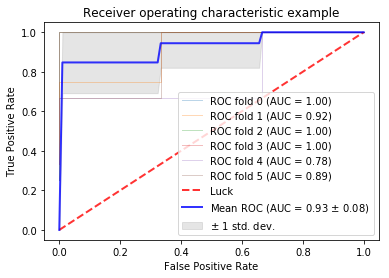

In [120]:
meu.draw_cv_roc_curve(trained_svm, cv_svm, train_x, train_y)

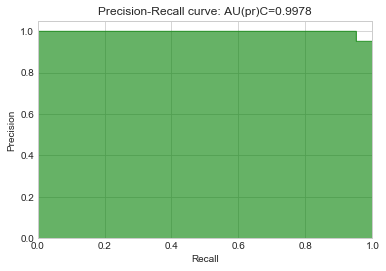

In [122]:
meu.plot_precision_recall_curve(trained_svm, test_x, test_y)

In [124]:
predictions = trained_svm.predict(test_x)

In [130]:
# Train and Test Accuracy
print("Train Accuracy :: ", accuracy_score(train_y, trained_svm.predict(train_x)))
print("Test Accuracy  :: ", accuracy_score(test_y, predictions))
print(" Confusion matrix: ")
confusion_matrix(test_y, predictions)

Train Accuracy ::  0.813186813187
Test Accuracy  ::  0.974358974359
 Confusion matrix: 


array([[17,  1],
       [ 0, 21]])

In [127]:
confusion_matrix(test_y, predictions)

array([[17,  1],
       [ 0, 21]])